<a href="https://colab.research.google.com/github/Chandramani05/NBA-Games-Data-Analysis-and-Match-Prediction/blob/main/NBA_Machine_Learning_Predicting_Scores_using_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np


##Data Pre-Processing

###Getting the Cleaned Stats Data

In [8]:
stats = pd.read_csv("/content/drive/MyDrive/Machine Learning NBA /NBA-Games-Data-Analysis-and-Match-Prediction/Final Data/stats_clean.csv")
stats


,id,ast,blk,dreb,fg3_pct,fg3a,fg3m,fg_pct,fga,fgm,...,turnover,game.id,game.date,game.home_team_id,game.home_team_score,game.season,game.visitor_team_id,game.visitor_team_score,player.id,team.id
0,1069106,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,45167,2019-01-17T00:00:00.000Z,12,96,2018,23,120,240.0,12
1,1069108,0.0,0.0,4.0,0.000000,1.0,0.0,0.667000,9.0,6.0,...,0.0,45206,2019-01-17T00:00:00.000Z,8,135,2018,5,105,222.0,5
2,1069109,1.0,0.0,9.0,0.500000,10.0,5.0,0.556000,18.0,10.0,...,2.0,45206,2019-01-17T00:00:00.000Z,8,135,2018,5,105,297.0,5
3,1069110,4.0,0.0,6.0,0.500000,2.0,1.0,0.308000,13.0,4.0,...,1.0,45206,2019-01-17T00:00:00.000Z,8,135,2018,5,105,377.0,5
4,1069111,6.0,0.0,3.0,0.000000,3.0,0.0,0.267000,15.0,4.0,...,2.0,45206,2019-01-17T00:00:00.000Z,8,135,2018,5,105,268.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968614,12398943,1.0,0.0,3.0,0.428571,7.0,3.0,0.545455,11.0,6.0,...,2.0,857658,2022-11-28T00:00:00.000Z,26,117,2022,24,122,272.0,24
968615,12399578,14.0,1.0,5.0,0.428571,7.0,3.0,0.454545,22.0,10.0,...,0.0,857660,2022-11-28T00:00:00.000Z,14,115,2022,12,116,3547245.0,12
968616,12399584,1.0,0.0,6.0,0.375000,8.0,3.0,0.454545,22.0,10.0,...,2.0,857660,2022-11-28T00:00:00.000Z,14,115,2022,12,116,38017686.0,12
968617,12399585,4.0,1.0,3.0,0.000000,2.0,0.0,0.166667,6.0,1.0,...,0.0,857660,2022-11-28T00:00:00.000Z,14,115,2022,12,116,304.0,12


In [9]:
stats['game.id'].nunique()

47655

In [10]:
stats["game.date"] = pd.to_datetime(stats["game.date"]).dt.tz_localize(None)

# Convert string to timedelta
stats["min"] = [pd.Timedelta(minutes=int(time[0]), seconds=int(time[1])) for time in stats["min"].str.split(":").values]

labels = stats[["game.id", "game.date", "game.season"]].groupby("game.id").first()

In [11]:
# split into 2 dataframes so that grouping data by game id doesn't
# group players of opposing teams
home_stats = stats[stats["team.id"].eq(stats["game.home_team_id"])]
away_stats = stats[stats["team.id"].eq(stats["game.visitor_team_id"])]

# define how to aggregate statistics when grouping player stats
agg_map = {"ast": "sum", 
           "blk": "sum", 
           "dreb": "sum", 
           "fg3_pct": "mean", 
           "fg3a": "sum", 
           "fg3m": "sum", 
           "fg_pct": "mean",
          "fga": "sum",
          "fgm": "sum",
          "ft_pct": "mean",
          "fta": "sum",
          "ftm": "sum",
          "min": "sum",
          "oreb": "sum",
          "pf": "sum",
          "pts": "sum",
          "reb": "sum",
          "stl": "sum",
          "turnover": "sum",
          "game.id": "first",
          "game.date": "first",
          "game.season": "first",
          "game.home_team_id": "first",
          "game.home_team_score": "first",
          "game.visitor_team_id": "first",
          "game.visitor_team_score": "first",
          "player.id": "first",
          "team.id": "first",}

# aggregate player stats to team stats
home_games = home_stats.groupby("game.id").agg(agg_map)
away_games = away_stats.groupby("game.id").agg(agg_map)

# player stats were aggregated to team stats, so player id doesn't make sense anymore
# team id isn't needed either
home_games.drop(["player.id", "team.id"], axis=1, inplace=True)
away_games.drop(["player.id", "team.id"], axis=1, inplace=True)

In [12]:
# Only use the columns that refer to stats when calculating the rolling average
stats_cols = ["ast","blk","dreb","fg3_pct","fg3a","fg3m","fg_pct","fga","fgm","ft_pct","fta","ftm","oreb",
              "pf","pts","reb","stl","turnover", 'game.home_team_score', 'game.home_team_id']

In [13]:
stas_col_away = ["ast","blk","dreb","fg3_pct","fg3a","fg3m","fg_pct","fga","fgm","ft_pct","fta","ftm","oreb",
              "pf","pts","reb","stl","turnover", 'game.visitor_team_score', 'game.visitor_team_id']

In [14]:
home_df = home_games[stats_cols].copy()
home_df = home_df.rename(columns = {'game.home_team_score' :'score', 'game.home_team_id':'id'})

In [15]:
away_df = away_games[stas_col_away].copy()
away_df = away_df.rename(columns = {'game.visitor_team_score' :'score', 'game.visitor_team_id':'id'})

In [16]:
home_df.head()

,ast,blk,dreb,fg3_pct,fg3a,fg3m,fg_pct,fga,fgm,ft_pct,fta,ftm,oreb,pf,pts,reb,stl,turnover,score,id
game.id,,,,,,,,,,,,,,,,,,,,
1,21.0,5.0,42.0,0.231417,37.0,11.0,0.331083,96.0,41.0,0.358333,14.0,10.0,12.0,20.0,103.0,54.0,7.0,14.0,105,2
2,28.0,7.0,41.0,0.140083,26.0,7.0,0.359000,95.0,42.0,0.241667,18.0,17.0,17.0,29.0,108.0,58.0,7.0,21.0,108,10
3,21.0,9.0,32.0,0.295500,38.0,16.0,0.445500,92.0,41.0,0.356700,22.0,14.0,9.0,19.0,112.0,41.0,8.0,11.0,112,4
4,21.0,5.0,32.0,0.288800,24.0,6.0,0.375200,92.0,39.0,0.456800,22.0,19.0,14.0,20.0,103.0,46.0,5.0,14.0,103,9
5,29.0,7.0,44.0,0.241667,26.0,10.0,0.495250,83.0,47.0,0.291667,13.0,7.0,13.0,24.0,111.0,57.0,2.0,20.0,111,12


In [17]:
away_df.head()

,ast,blk,dreb,fg3_pct,fg3a,fg3m,fg_pct,fga,fgm,ft_pct,fta,ftm,oreb,pf,pts,reb,stl,turnover,score,id
game.id,,,,,,,,,,,,,,,,,,,,
1,18.0,5.0,41.0,0.071455,26.0,5.0,0.336545,87.0,34.0,0.277273,23.0,14.0,6.0,20.0,87.0,47.0,8.0,16.0,87,23
2,21.0,6.0,29.0,0.149900,37.0,10.0,0.334200,91.0,33.0,0.455000,37.0,24.0,16.0,21.0,100.0,45.0,12.0,14.0,100,21
3,26.0,4.0,46.0,0.366600,34.0,14.0,0.498200,85.0,42.0,0.358300,20.0,15.0,11.0,25.0,113.0,57.0,5.0,21.0,113,17
4,28.0,5.0,34.0,0.173333,27.0,5.0,0.441556,82.0,40.0,0.358333,22.0,15.0,5.0,23.0,100.0,39.0,9.0,17.0,100,3
5,16.0,3.0,21.0,0.278818,29.0,10.0,0.304273,84.0,25.0,0.417182,28.0,23.0,7.0,18.0,83.0,28.0,11.0,7.0,83,15


In [18]:
# Rename columns in the home and away dataframes
home_df.columns = ["home_" + col_name for col_name in home_df.columns]
away_df.columns = ["away_" + col_name for col_name in away_df.columns]
# Now that columns are renamed they can be merged into the same dataframe
rolling_stats = pd.merge(home_df, away_df, on="game.id")

##Final Data to be given to ML Model

In [19]:
rolling_stats

,home_ast,home_blk,home_dreb,home_fg3_pct,home_fg3a,home_fg3m,home_fg_pct,home_fga,home_fgm,home_ft_pct,...,away_fta,away_ftm,away_oreb,away_pf,away_pts,away_reb,away_stl,away_turnover,away_score,away_id
game.id,,,,,,,,,,,,,,,,,,,,,
1,21.0,5.0,42.0,0.231417,37.0,11.0,0.331083,96.0,41.0,0.358333,...,23.0,14.0,6.0,20.0,87.0,47.0,8.0,16.0,87,23
2,28.0,7.0,41.0,0.140083,26.0,7.0,0.359000,95.0,42.0,0.241667,...,37.0,24.0,16.0,21.0,100.0,45.0,12.0,14.0,100,21
3,21.0,9.0,32.0,0.295500,38.0,16.0,0.445500,92.0,41.0,0.356700,...,20.0,15.0,11.0,25.0,113.0,57.0,5.0,21.0,113,17
4,21.0,5.0,32.0,0.288800,24.0,6.0,0.375200,92.0,39.0,0.456800,...,22.0,15.0,5.0,23.0,100.0,39.0,9.0,17.0,100,3
5,29.0,7.0,44.0,0.241667,26.0,10.0,0.495250,83.0,47.0,0.291667,...,28.0,23.0,7.0,18.0,83.0,28.0,11.0,7.0,83,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857658,32.0,7.0,29.0,0.351852,25.0,9.0,0.484757,86.0,45.0,0.607407,...,12.0,10.0,10.0,17.0,111.0,42.0,9.0,14.0,122,24
857659,29.0,3.0,30.0,0.410511,49.0,19.0,0.478263,84.0,40.0,0.333333,...,25.0,22.0,13.0,17.0,114.0,50.0,6.0,7.0,114,5
857660,23.0,7.0,39.0,0.324074,31.0,11.0,0.386965,91.0,39.0,0.587037,...,16.0,13.0,11.0,19.0,116.0,46.0,6.0,7.0,116,12


##Aggregate Home Score

In [20]:
import plotly.express as px
fig = px.histogram(rolling_stats, x="home_score", nbins=20)
fig.update_layout(title_text='Home_Score')
fig.show()

##Aggregate Away Score

In [73]:
fig = px.histogram(rolling_stats, x="away_score", nbins=20)
fig.update_layout(title_text='Away Score Distributin')
fig.show()

#Machine Learning for the Scores Using DNN

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [23]:
# Split the data into train and test with 80 train / 20 test
train,test = train_test_split(rolling_stats, test_size=0.2, random_state = 1)
train,val = train_test_split(train, test_size=0.2, random_state = 1)

In [24]:
# Helper functions
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
def format_output(data):
    y1 = data.pop('home_score')
    y1 = np.array(y1)
    y2 = data.pop('away_score')
    y2 = np.array(y2)
    return y1, y2

In [25]:
# Get PRICE and PTRATIO as the 2 outputs and format them as np arrays
# PTRATIO - pupil-teacher ratio by town
train_stats = train.describe()
train_stats.pop('home_score')
train_stats.pop('away_score')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)
val_Y = format_output(val)

print(train_stats)


                 count        mean        std      min        25%         50%  \
home_ast       30496.0   23.755443   5.619282   5.0000  20.000000   23.000000   
home_blk       30496.0    5.345488   2.779990   0.0000   3.000000    5.000000   
home_dreb      30496.0   31.207011   5.584816  13.0000  27.000000   31.000000   
home_fg3_pct   30496.0    2.432925   7.762605   0.0000   0.090909    0.158962   
home_fg3a      30496.0   16.792301  10.311623   0.0000   9.000000   15.000000   
home_fg3m      30496.0    5.977932   4.300342   0.0000   3.000000    5.000000   
home_fg_pct    30496.0    4.218449  12.387614   0.1755   0.379720    0.436300   
home_fga       30496.0   83.600702   8.590791  49.0000  78.000000   83.000000   
home_fgm       30496.0   38.978030   5.966335  17.0000  35.000000   39.000000   
home_ft_pct    30496.0    4.279849  12.837312   0.0000   0.388300    0.480000   
home_fta       30496.0   25.967110   8.405812   1.0000  20.000000   25.000000   
home_ftm       30496.0   19.

In [26]:
# Normalize the training and test data
norm_train_X = np.array(norm(train))
norm_test_X = np.array(norm(test))
norm_val_X = np.array(norm(val))

In [43]:
from keras.models import Model
from keras.layers import * 

In [50]:
checkpoint_no = 'ANN_Model'
model_name = 'Model_Score'

input_shape = norm_train_X.shape[1]

n_batch_size = 48

n_steps_per_epoch = int(norm_train_X.shape[0] / n_batch_size)
n_validation_steps = int(norm_val_X.shape[0] / n_batch_size)
n_test_steps = int(norm_test_X.shape[0] / n_batch_size)

n_epochs = 500

###Building the model

In [51]:
def build_model():
    # Define model layers.
    input_layer = Input(shape=(len(train .columns),))
    first_dense = Dense(256,kernel_initializer='normal', activation='relu')(input_layer)
    first_dense = Dense(256, kernel_initializer='normal',activation='relu')(first_dense)
    first_dense = Dense(256, kernel_initializer='normal',activation='relu')(first_dense)
    # Y1 output will be fed from the first dense
    y1_output = Dense(units='1', name='home_output')(first_dense)
    second_dense = Dense(256,kernel_initializer='normal', activation='relu')(input_layer)
    second_dense = Dense(256, kernel_initializer='normal',activation='relu')(second_dense)
    second_dense = Dense(256, kernel_initializer='normal',activation='relu')(second_dense)
    # Y2 output will be fed from the second dense
    y2_output = Dense(units='1',name='away_output')(second_dense)
    # Define the model with the input layer 
    # and a list of output layers
    model = Model(inputs=input_layer,outputs=[y1_output, y2_output])
    model.summary()
    return model

In [52]:
import os
# Prepare a directory to store all the checkpoints.
checkpoint_dir = '/content/drive/MyDrive/Machine Learning NBA /NBA-Games-Data-Analysis-and-Match-Prediction/Models'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [53]:
model = build_model()
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'home_output': 'mse', 'away_output': 'mse'},
 metrics={'home_output':['mae', 'mse'],
          'away_output':['mae', 'mse']})

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          9984        ['input_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 256)          9984        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                              

###Saving the Model

In [54]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [55]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

###Training the Model

In [56]:
# Train the model for 100 epochs
history = model.fit(norm_train_X,
                    train_Y,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(norm_val_X, val_Y),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

Epoch 1/500
635/635 [==============================] - 9s 13ms/step - loss: 786.9658 - home_output_loss: 408.9918 - away_output_loss: 377.9738 - home_output_mae: 9.3133 - home_output_mse: 408.9918 - away_output_mae: 9.0013 - away_output_mse: 377.9738 - val_loss: 18.3468 - val_home_output_loss: 9.2815 - val_away_output_loss: 9.0653 - val_home_output_mae: 1.8138 - val_home_output_mse: 9.2815 - val_away_output_mae: 1.7462 - val_away_output_mse: 9.0653
Epoch 2/500
635/635 [==============================] - 6s 10ms/step - loss: 15.4881 - home_output_loss: 7.8172 - away_output_loss: 7.6710 - home_output_mae: 1.5507 - home_output_mse: 7.8172 - away_output_mae: 1.5586 - away_output_mse: 7.6710 - val_loss: 16.4057 - val_home_output_loss: 8.2713 - val_away_output_loss: 8.1344 - val_home_output_mae: 1.5504 - val_home_output_mse: 8.2713 - val_away_output_mae: 1.6350 - val_away_output_mse: 8.1344
Epoch 3/500
635/635 [==============================] - 7s 11ms/step - loss: 13.6455 - home_output_loss:

In [57]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv('/content/drive/MyDrive/Machine Learning NBA /NBA-Games-Data-Analysis-and-Match-Prediction/Modelsckpt_1_ANN'+ '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,home_output_loss,away_output_loss,home_output_mae,home_output_mse,away_output_mae,away_output_mse,val_loss,val_home_output_loss,val_away_output_loss,val_home_output_mae,val_home_output_mse,val_away_output_mae,val_away_output_mse
0,1,786.965820,408.991791,377.973785,9.313273,408.991791,9.001320,377.973785,18.346815,9.281485,9.065328,1.813832,9.281485,1.746193,9.065328
1,2,15.488143,7.817161,7.670982,1.550707,7.817161,1.558629,7.670982,16.405706,8.271260,8.134447,1.550435,8.271260,1.634966,8.134447
2,3,13.645542,6.906972,6.738576,1.455848,6.906972,1.469405,6.738576,15.044153,7.957119,7.087036,1.779268,7.957119,1.554647,7.087036
3,4,12.183376,6.314927,5.868451,1.465140,6.314927,1.401282,5.868451,12.742483,6.837232,5.905252,1.747998,6.837232,1.520090,5.905252
4,5,11.871023,5.939864,5.931155,1.413639,5.939864,1.459226,5.931155,10.478197,5.318405,5.159794,1.392352,5.318405,1.399923,5.159794


In [58]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,home_output_loss,away_output_loss,home_output_mae,home_output_mse,away_output_mae,away_output_mse,val_loss,val_home_output_loss,val_away_output_loss,val_home_output_mae,val_home_output_mse,val_away_output_mae,val_away_output_mse
429,430,0.314553,0.158398,0.156155,0.209998,0.158398,0.204413,0.156155,0.87894,0.43501,0.44393,0.203164,0.43501,0.170379,0.44393


##Testing the Model

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import confusion_matrix

In [42]:
best_model = load_model('/content/drive/MyDrive/Machine Learning NBA /NBA-Games-Data-Analysis-and-Match-Prediction/ModelsANN_Model/Model_Score')

In [33]:
hist_df = pd.read_csv('/content/drive/MyDrive/Machine Learning NBA /NBA-Games-Data-Analysis-and-Match-Prediction/Modelsckpt_1_ANN/history_df_Model_Score.csv')
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,Unnamed: 0,epoch,loss,home_output_loss,away_output_loss,home_output_mae,home_output_mse,away_output_mae,away_output_mse,val_loss,val_home_output_loss,val_away_output_loss,val_home_output_mae,val_home_output_mse,val_away_output_mae,val_away_output_mse
429,429,430,0.314553,0.158398,0.156155,0.209998,0.158398,0.204413,0.156155,0.87894,0.43501,0.44393,0.203164,0.43501,0.170379,0.44393


###Training and Validation Loss

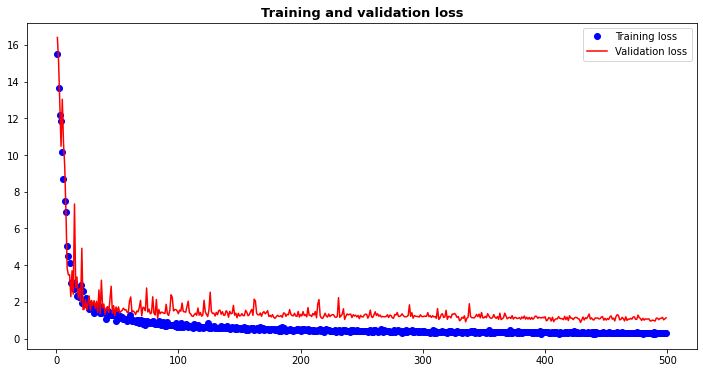

In [39]:
loss = hist_df['loss']
val_loss = hist_df['val_loss']
loss = loss[1:]
val_loss = val_loss[1:]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12,6))
plt.plot(epochs, loss, 'bo',color = 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b',color = 'r', label='Validation loss')
plt.title('Training and validation loss', fontdict={'weight' :'bold', 'size' : '13'})
plt.savefig('/content/drive/MyDrive/Machine Learning NBA /NBA-Games-Data-Analysis-and-Match-Prediction/Figures/Training and Validation loss.png')
plt.legend()

In [63]:
def plot_diff(y_true, y_pred, title=''):
    plt.figure(figsize=(12,6))
    plt.scatter(y_true, y_pred)
    plt.title(title, fontdict={'weight' :'bold', 'size' : '13'})
    plt.xlabel('True Values',fontdict={'weight' :'bold', 'size' : '10'})
    plt.ylabel('Predictions',fontdict={'weight' :'bold', 'size' : '10'})
    plt.axis('equal')
    plt.axis('square')
    plt.savefig('/content/drive/MyDrive/Machine Learning NBA /NBA-Games-Data-Analysis-and-Match-Prediction/Figures/' + title +'.png')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim):
    plt.figure(figsize=(12,6))
    plt.title(title,fontdict={'weight' :'bold', 'size' : '13'})
    plt.ylim(0, ylim)
    plt.plot(hist_df[metric_name], color='blue', label=metric_name)
    plt.plot(hist_df['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.savefig('/content/drive/MyDrive/Machine Learning NBA /NBA-Games-Data-Analysis-and-Match-Prediction/Figures/' + title +'.png')
    plt.show()

In [70]:
def plot_confusion_matrix(y_true, y_pred, title='') :
  conf_mat = confusion_matrix(y_true, y_pred)
  conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
  sns.heatmap(conf_mat_normalized)
  plt.title("Confusion Matrix " +  title, fontdict={'weight' :'bold', 'size' : '13'})
  plt.ylabel('True label', fontdict={'weight' :'bold', 'size' : '10'})
  plt.xlabel('Predicted label',fontdict={'weight' :'bold', 'size' : '10'})

298/298 [==============================] - 1s 3ms/step


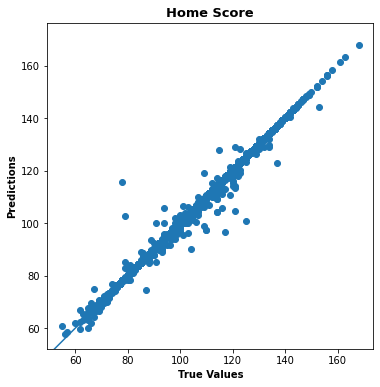

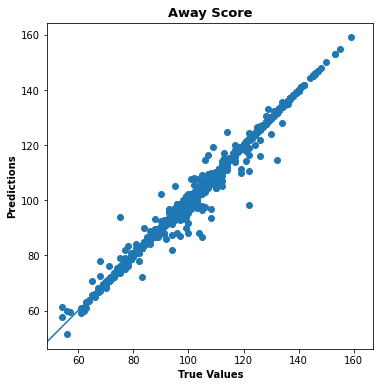

In [60]:
# Run predict
Y_pred = best_model.predict(norm_test_X)
home_predict = Y_pred[0]
away_predict = Y_pred[1]
plot_diff(test_Y[0], Y_pred[0], title='Home Score')
plot_diff(test_Y[1], Y_pred[1], title='Away Score')

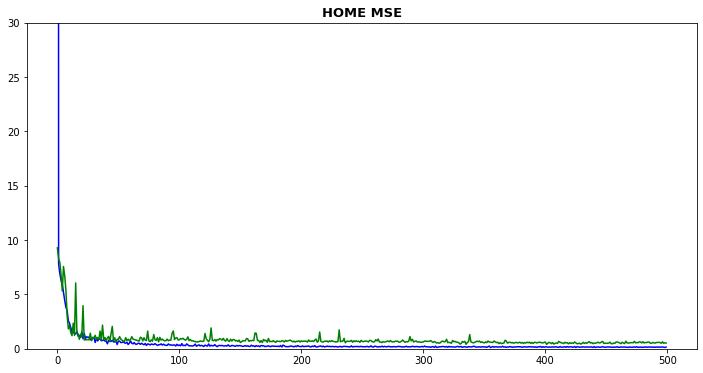

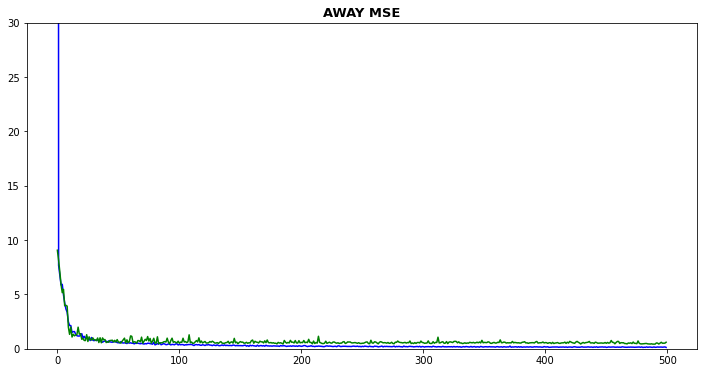

In [65]:
# Plot RMSE
plot_metrics(metric_name='home_output_mse', title='HOME MSE', ylim=30)
plot_metrics(metric_name='away_output_mse', title='AWAY MSE', ylim=30)

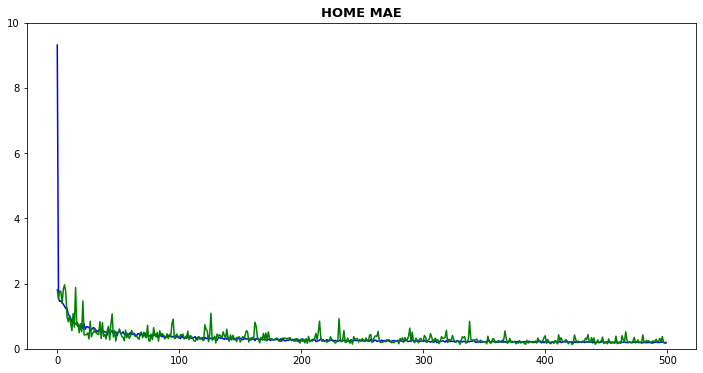

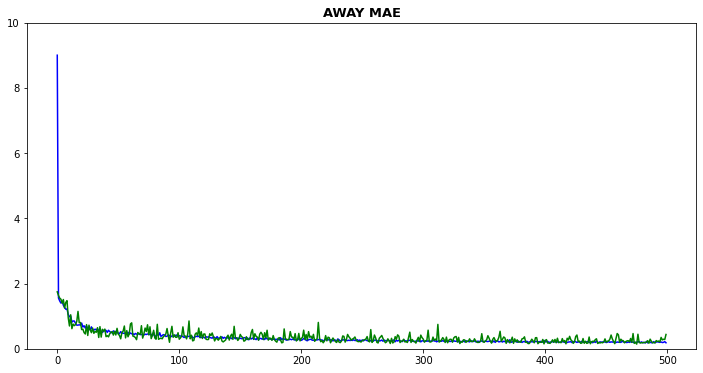

In [67]:
# Plot MAE
plot_metrics(metric_name='home_output_mae', title='HOME MAE', ylim=10)
plot_metrics(metric_name='away_output_mae', title='AWAY MAE', ylim=10)

In [78]:
# Save model
best_model.save('/content/drive/MyDrive/Machine Learning NBA /NBA-Games-Data-Analysis-and-Match-Prediction/Models/ANN/', save_format='tf')

In [79]:
# Restore model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Machine Learning NBA /NBA-Games-Data-Analysis-and-Match-Prediction/Models/ANN')

In [76]:

# Run predict with restored model
predictions = loaded_model.predict(norm_test_X)
home = predictions[0]
away = predictions[1]


298/298 [==============================] - 1s 3ms/step


In [77]:
home


array([[ 97.16861],
       [ 93.87969],
       [ 67.75233],
       ...,
       [ 97.21352],
       [ 99.05585],
       [110.10729]], dtype=float32)